Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100000.00


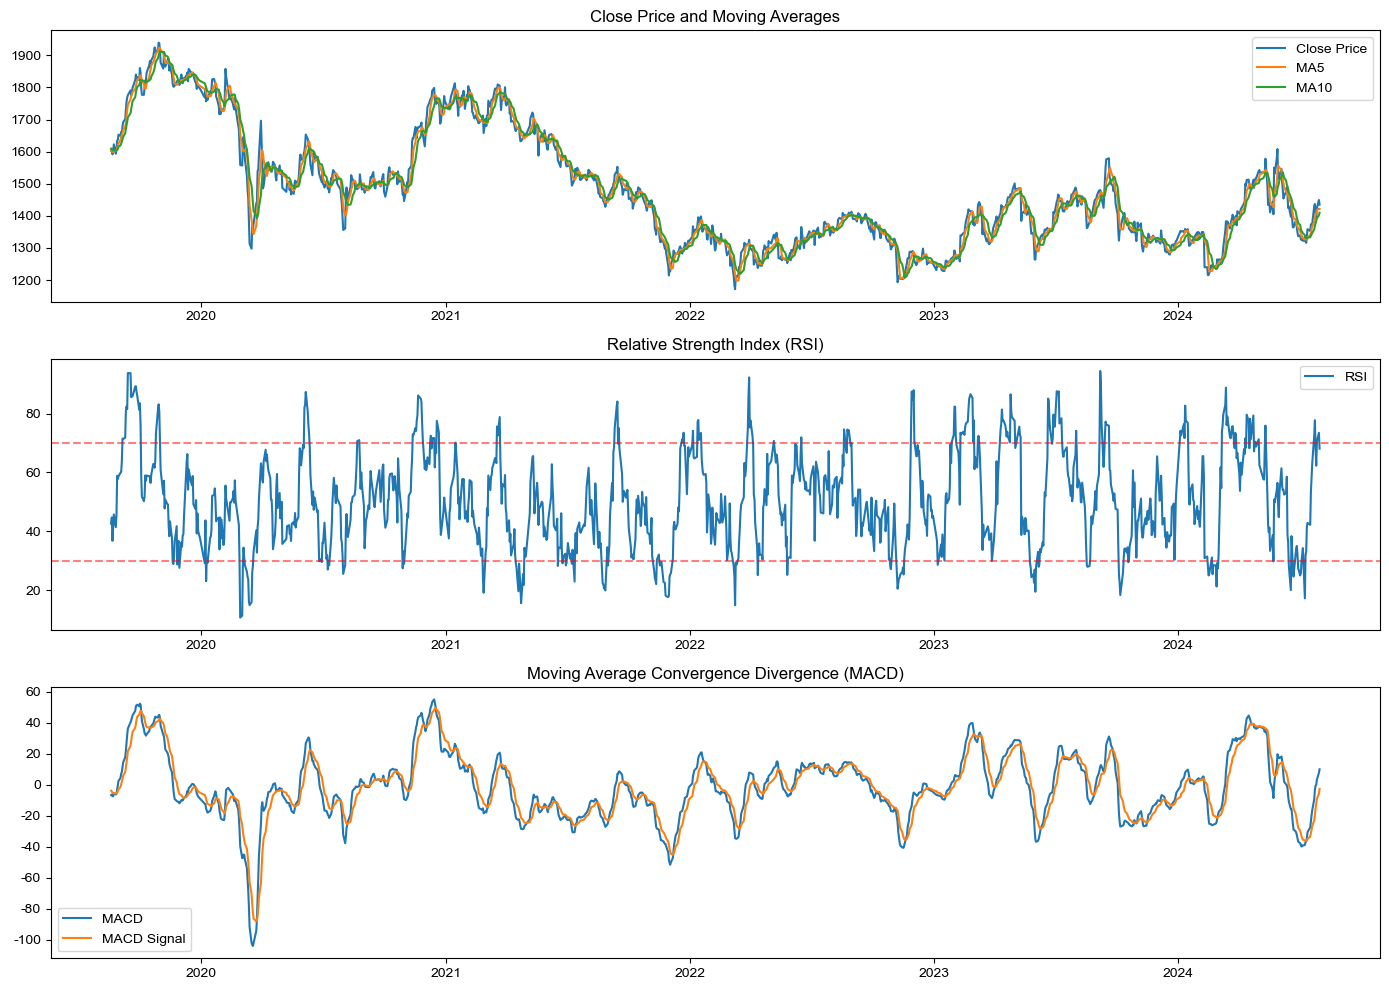

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import backtrader as bt

# Set English font
plt.rcParams['font.sans-serif'] = ['Arial']  # Use Arial font
plt.rcParams['axes.unicode_minus'] = False  # Solve minus sign display issue

# Get stock data
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# Compute Relative Strength Index (RSI)
def compute_rsi(data, period):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Compute Moving Average Convergence Divergence (MACD)
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Custom Indicator Classes
class MA5(bt.Indicator):
    lines = ('ma5',)
    params = (('period', 5),)

    def __init__(self):
        self.lines.ma5 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)

class MA10(bt.Indicator):
    lines = ('ma10',)
    params = (('period', 10),)

    def __init__(self):
        self.lines.ma10 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)

class RSI(bt.Indicator):
    lines = ('rsi',)
    params = (('period', 14),)

    def __init__(self):
        self.lines.rsi = bt.indicators.RSI(self.data.close, period=self.params.period)

class MACD(bt.Indicator):
    lines = ('macd', 'macd_signal')
    params = (('short_period', 12), ('long_period', 26), ('signal_period', 9),)

    def __init__(self):
        macd = bt.indicators.EMA(self.data.close, period=self.params.short_period) - bt.indicators.EMA(self.data.close, period=self.params.long_period)
        self.lines.macd = macd
        self.lines.macd_signal = bt.indicators.EMA(macd, period=self.params.signal_period)

# Preprocess data
def preprocess_data(data):
    data['Target'] = np.where(data['close'].shift(-1) > data['close'], 1, 0)
    data = data.dropna()
    features = data[['open', 'high', 'low', 'close', 'ma5', 'ma10', 'rsi', 'macd', 'macd_signal']]
    target = data['Target']
    return features, target, data

# Define Backtrader Strategy
class MLStrategy(bt.Strategy):
    params = dict(
        model=None,
        window=1
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.model = self.params.model
        
        # Add custom indicators
        self.ma5 = MA5(self.data)
        self.ma10 = MA10(self.data)
        self.rsi = RSI(self.data)
        self.macd = MACD(self.data)
        
        # Track buy/sell signals
        self.buy_signal = []
        self.sell_signal = []
        
    def next(self):
        if len(self) < self.params.window:
            return
        
        # Get current feature data
        current_features = pd.DataFrame({
            'open': [self.data.open[0]],
            'high': [self.data.high[0]],
            'low': [self.data.low[0]],
            'close': [self.data.close[0]],
            'ma5': [self.ma5.lines.ma5[0]],
            'ma10': [self.ma10.lines.ma10[0]],
            'rsi': [self.rsi.lines.rsi[0]],
            'macd': [self.macd.lines.macd[0]],
            'macd_signal': [self.macd.lines.macd_signal[0]]
        })
        
        # Make prediction
        prediction = self.model.predict(current_features)[0]
        
        # Execute trades based on prediction
        if prediction == 1 and not self.position:
            self.buy(size=100)
            self.buy_signal.append(self.data.datetime.datetime())
        elif prediction == 0 and self.position:
            self.sell(size=100)
            self.sell_signal.append(self.data.datetime.datetime())

    def notify_trade(self, trade):
        if trade.isclosed and len(trade.history) > 0:
            print('Action: {}  Price: {}  Profit: {}'.format(
                'Buy' if trade.history[0].event.size > 0 else 'Sell',
                trade.price,
                trade.pnl))

def main(stock_code):
    data = get_stock_data(stock_code)
    data['ma5'] = data['Close'].rolling(window=5).mean()
    data['ma10'] = data['Close'].rolling(window=10).mean()
    data['rsi'] = compute_rsi(data['Close'], 14)
    data['macd'], data['macd_signal'] = compute_macd(data['Close'])

    # Convert column names to lowercase
    data.columns = [col.lower() for col in data.columns]

    data = data.dropna()
    
    features, target, full_data = preprocess_data(data)

    # Split training and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # Create XGBoost model
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(x_train, y_train)

    # Create Backtrader engine
    cerebro = bt.Cerebro()

    # Load data
    datafeed = bt.feeds.PandasData(dataname=full_data)
    cerebro.adddata(datafeed)

    # Add strategy
    cerebro.addstrategy(MLStrategy, model=model)

    # Set initial cash
    cerebro.broker.set_cash(100000.0)

    # Set commission
    cerebro.broker.setcommission(commission=0.001)

    # Run backtest
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot results
    plt.figure(figsize=(14, 10))

    # Plot close price and moving averages
    plt.subplot(3, 1, 1)
    plt.plot(full_data.index, full_data['close'], label='Close Price')
    plt.plot(full_data.index, full_data['ma5'], label='MA5')
    plt.plot(full_data.index, full_data['ma10'], label='MA10')
    plt.title('Close Price and Moving Averages')
    plt.legend()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(full_data.index, full_data['rsi'], label='RSI')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='r')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(full_data.index, full_data['macd'], label='MACD')
    plt.plot(full_data.index, full_data['macd_signal'], label='MACD Signal')
    plt.title('Moving Average Convergence Divergence (MACD)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    stock_code = input("Enter stock code: ")
    main(stock_code)